In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
from pyvi import ViTokenizer
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load dataset
df = pd.read_csv('fashion_comment_data.csv')

### Overview of data

In [3]:
df.head()

,ProductID,Clothes Type,Price,Selled Quantity,Overall Rating,sentiment_appearance,sentiment_delivery,sentiment_fabric_quality,sentiment_others,sentiment_packaging,sentiment_price,sentiment_service,sentiment_size_fit,text
0,1,Women's Shirt,161000,9,5.0,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,Đẹp vải măc mát.
1,2,Women's Shirt,112000,0,5.0,NaN,NaN,NaN,NaN,positive,NaN,NaN,NaN,Rất thích các áo in của Goking. Ý nghĩa. Chất ...
2,2,Women's Shirt,112000,0,5.0,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,"Áo phông mặc mát, hình in mềm mại. Đúng là hàn..."
3,3,Women's Shirt,62000,14,5.0,positive,NaN,positive,NaN,NaN,NaN,NaN,NaN,Dù đôi chỗ còn may chưa đẹp lắm nhưng được cái...
4,3,Women's Shirt,62000,14,5.0,positive,NaN,positive,NaN,NaN,NaN,NaN,NaN,"Hình in rất sắc nét, mềm mại, không dính. Rất ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5500 entries, 0 to 5499
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ProductID                 5500 non-null   int64  
 1   Clothes Type              5500 non-null   object 
 2   Price                     5500 non-null   int64  
 3   Selled Quantity           5500 non-null   object 
 4   Overall Rating            5500 non-null   float64
 5   sentiment_appearance      2110 non-null   object 
 6   sentiment_delivery        701 non-null    object 
 7   sentiment_fabric_quality  1812 non-null   object 
 8   sentiment_others          1494 non-null   object 
 9   sentiment_packaging       262 non-null    object 
 10  sentiment_price           360 non-null    object 
 11  sentiment_service         241 non-null    object 
 12  sentiment_size_fit        702 non-null    object 
 13  text                      5500 non-null   object 
dtypes: float

### Normalize and correct misspelled and wrong words using a manual dictionary

In [5]:
df.columns = ['ProductID', 'Clothes Type', 'Price', 'Selled Quantity', 'Overall Rating', 'appearance', 'delivery', 'fabric_quality', 'others', 'packaging', 'price', 'service', 'size_fit', 'text']

In [6]:
# to lowercase
df['processed_text'] = df['text'].apply(lambda x: x.lower())

# drop punctuation
df['processed_text'] = df['processed_text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

# drop space
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x.split()))

In [ ]:
# replace words by manually dictionary
with open('dictionary_edit.json', 'r') as file:
    correction_map = json.load(file)

apply_map = {}
for key, values in correction_map.items():
    if key != values:
        apply_map[key] = values

def replace_words(text, correction_map):
    words = text.split()
    replaced_words = [correction_map.get(word, word) for word in words]
    return ' '.join(replaced_words)

df['processed_text'] = df['processed_text'].apply(lambda x: replace_words(x, correction_map=apply_map))

In [8]:
df[df['processed_text'].str.contains(" xem thêm")]['processed_text'].count()

117

> we can see that there are 117 rows that contain the word " xem thêm" in the 'processed_text' column because the wrong of crawling data process. We need to remove them.

In [9]:
df['processed_text'] = df['processed_text'].apply(lambda x: x.replace(' xem thêm', ''))

In [ ]:
# remove remove duplicated data
df.drop_duplicates(subset='processed_text', keep='first', inplace=True)

### Visualization

<Figure size 1200x1000 with 0 Axes>

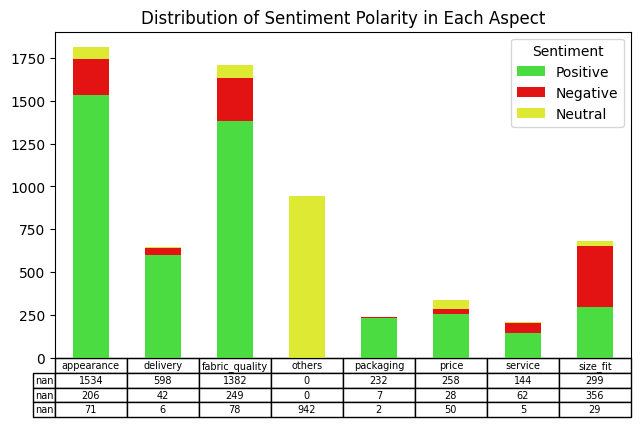

In [ ]:
columns = ['appearance', 'delivery', 'fabric_quality', 'others', 'packaging', 'price', 'service', 'size_fit']
distribution_df = pd.concat([df[column].value_counts(dropna=True) for column in columns], axis=1)
distribution_df.columns = columns
distribution_df = distribution_df.fillna(0)

plt.figure(figsize=(12, 10))
distribution_df.T.plot(kind='bar', stacked=True, color=['#4ADC40', '#E41313', '#DDE933'])
plt.title('Distribution of Sentiment Polarity in Each Aspect')
plt.legend(title='Sentiment', labels=['Positive', 'Negative', 'Neutral'])
plt.xticks([])

# Add the table below the bar chart
table_data = distribution_df.values.astype('int32')
row_labels = distribution_df.index.map({1: 'negative', 2: 'neutral', 3: 'positive'}).tolist()
table = plt.table(cellText=table_data, rowLabels=row_labels, colLabels=columns, loc='bottom', cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(7)

# Adjust the layout to make room for the table
plt.subplots_adjust(left=0, bottom=0.2)

plt.show()

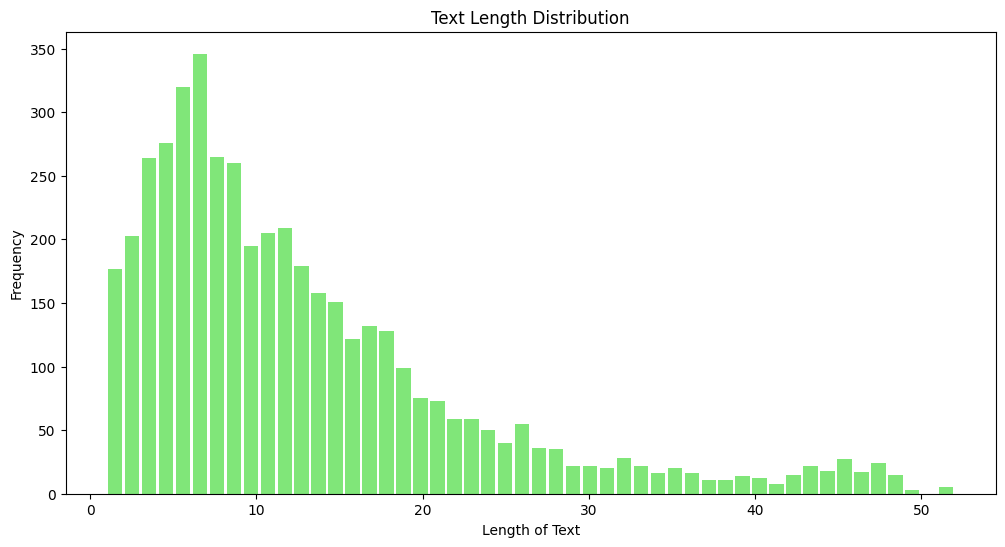

In [12]:
# Calculate the length of each text
df_len_text = df['processed_text'].apply(lambda x: len(x.split(' ')))

# Plot a histogram of text lengths
plt.figure(figsize=(12, 6))
plt.hist(df_len_text, bins=50, color='#4ADC40', alpha=0.7, rwidth=0.85)
plt.title('Text Length Distribution')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()

> We can see that the length of text is mostly between 10 and 20 words.

### Tokenize and drop columns

In [ ]:
# Use tokenizer form pyvi library
df['processed_text'] = df['processed_text'].apply(lambda x: ViTokenizer.tokenize(x))

In [14]:
df.drop(columns=['ProductID', 'Clothes Type', 'Price', 'Selled Quantity',
       'Overall Rating', 'text'], inplace=True)

In [15]:
mapping_values = {"positive":3, "neutral":2, "negative":1, np.nan:0}

df[df.columns[:-1]] = df[df.columns[:-1]].applymap(lambda x: mapping_values[x])

### Split to train, val, test

In [16]:
from sklearn.model_selection import train_test_split

data_train, data_temp = train_test_split(df, test_size=0.2, random_state=42)
data_val, data_test = train_test_split(data_temp, test_size=0.5, random_state=42)

In [17]:
def calculate_statistics(df):
    num_reviews = len(df)
    avg_aspects_per_review = df.iloc[:, :-1].astype(bool).sum(axis=1).mean()

    positive_count = (df.iloc[:, :-1] == 3).sum().sum()
    neutral_count = (df.iloc[:, :-1] == 2).sum().sum()
    negative_count = (df.iloc[:, :-1] == 1).sum().sum()
    total_sentiments = positive_count + neutral_count + negative_count

    return [num_reviews, avg_aspects_per_review, positive_count, neutral_count, negative_count, total_sentiments]

train_stats = calculate_statistics(data_train)
dev_stats = calculate_statistics(data_val)
test_stats = calculate_statistics(data_test)

summary_df = pd.DataFrame(
    [train_stats, dev_stats, test_stats],
    columns=["Review", "Avg aspect/ review", "Positive", "Neutral", "Negative", "Total sentiment"],
    index=["Train", "Val", "Test"]
)

summary_df

,Review,Avg aspect/ review,Positive,Neutral,Negative,Total sentiment
Train,3631,1.458276,3584,940,771,5295
Val,454,1.389868,412,119,100,631
Test,454,1.440529,451,124,79,654


In [ ]:
# Save to csv file
data_train.to_csv('data_train.csv', index=False)
data_val.to_csv('data_val.csv', index=False)
data_test.to_csv('data_test.csv', index=False)